## Peak detection

In [2]:
import numpy as np
import scipy
import scipy.signal
import scipy.interpolate
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import csv
from matplotlib import pyplot as plt
DATADIR = "../data-source"
OUTPUTDIR = "./output"

In [3]:
def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

In [4]:
path = f"{DATADIR}/2-11-21/ALL0017/F0017MTH.CSV"
adc_f = openTek(path)['Data'].to_numpy().transpose()
adc_time = adc_f[0]
adc_code = adc_f[1]

In [5]:
p = list(scipy.signal.find_peaks(adc_code * -1., distance=40))[0]
#Other useful parameters:
#prominence
#threshold
#please see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# ^^^ Fare fine tuning di questi parametri finché non va

# SPLINE
xint = np.linspace(adc_time.min(), adc_time.max(), 500) 
spl = make_interp_spline(adc_time[p], adc_code[p], k=1)  # type: BSpline
interp = spl(xint)

# E' anche interessante provare a cambiare il tipo di interpolazione, per esempio usare una sinc (sinx/x)

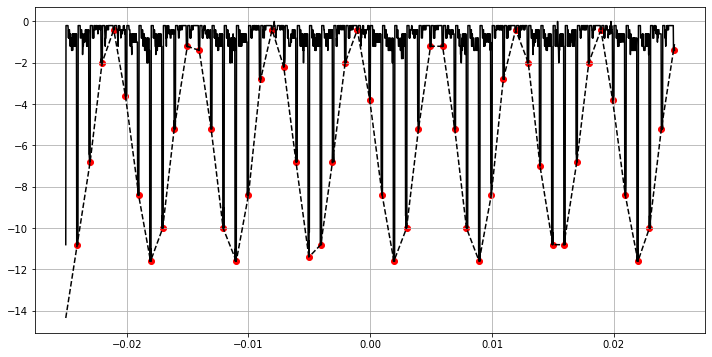

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax.grid()
ax.plot(adc_time, adc_code, color='black')
ax.scatter(adc_time[p], adc_code[p], color = "red")
ax.plot(xint, interp, color = "black", linestyle = "--")

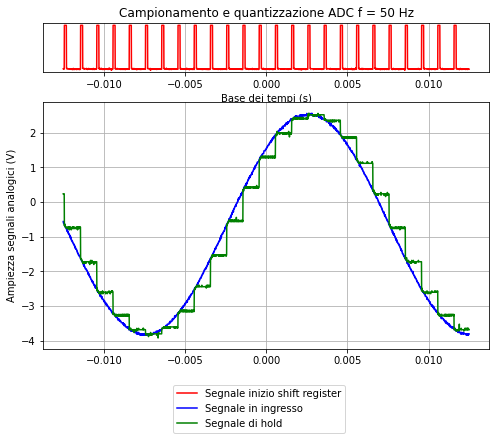

In [11]:
s = '00'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]




gs_kw = dict(height_ratios=[1,5])
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 50 Hz")
ax[1].plot(ch1_t, ch1_s, color = "blue", label = "Segnale in ingresso") #Campionamento all bits
ax[1].plot(ch2_t, ch2_s, color = "green", label = "Segnale di hold") #Campionamento all bits

ax[0].plot(ch3_t, ch3_s, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()

ax[-2].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.08))

plt.savefig(f"{OUTPUTDIR}/campionamento_no_mth_50Hz.pdf")

### Nyquist Teorem

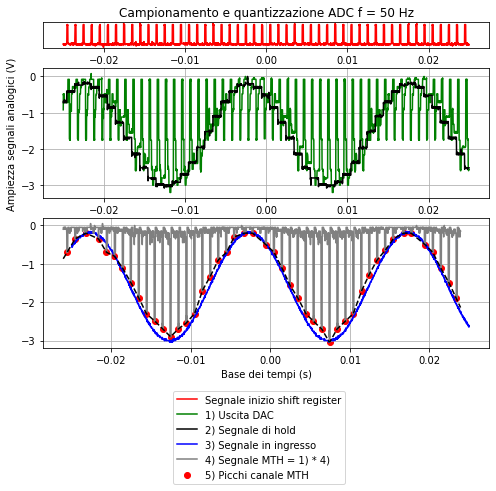

In [28]:
s = '16'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()
ch4_f = openTek(filePrefix + s+"CH4.CSV")['Data'].to_numpy().transpose()
mth_f = openTek(filePrefix + s+"MTH.CSV")['Data'].to_numpy().transpose()

sf = 0.00107

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]
ch4_t = ch4_f[0]
ch4_s = ch4_f[1]
mth_t = mth_f[0]-sf
mth_s = mth_f[1]/ch2_s.max()

p = list(scipy.signal.find_peaks(mth_s * -1., distance=40))[0]

xint = np.linspace(mth_t.min(), mth_t.max(), 500) 
spl = make_interp_spline(mth_t[p], mth_s[p], k=1)  # type: BSpline
interp = spl(xint)

gs_kw = dict(height_ratios=[1,5,5])
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 50 Hz")
ax[1].plot(ch1_t, ch1_s, color = "green", label = "1) Uscita DAC") #Campionamento all bits
ax[1].plot(ch3_t, ch3_s, color = "black", label="2) Segnale di hold")
ax[2].plot(ch4_t, ch4_s, color = "blue", label="3) Segnale in ingresso")
ax[2].plot(mth_t, mth_s, color = "grey", label="4) Segnale MTH = 1) * 4)")

ax[2].scatter(mth_t[p], mth_s[p], color = "red",label = "5) Picchi canale MTH")
ax[2].plot(xint, interp, color = "black", linestyle = "--")

ax[0].plot(ch2_t, ch2_s/5, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[-1].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.2))

plt.savefig(f"{OUTPUTDIR}/campionamento_50Hz.pdf")

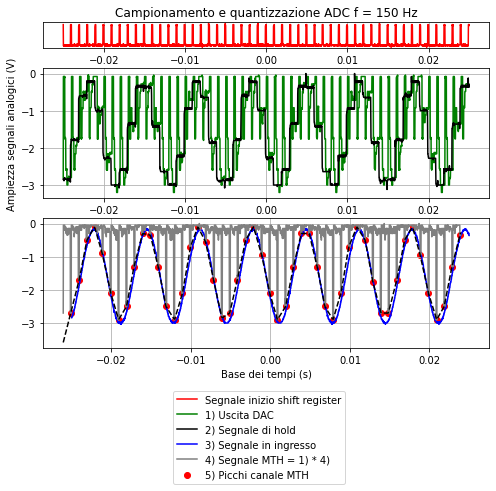

In [29]:
s = '17'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()
ch4_f = openTek(filePrefix + s+"CH4.CSV")['Data'].to_numpy().transpose()
mth_f = openTek(filePrefix + s+"MTH.CSV")['Data'].to_numpy().transpose()


sf = 0.00107

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]
ch4_t = ch4_f[0]
ch4_s = ch4_f[1]
mth_t = mth_f[0]-sf
mth_s = mth_f[1]/ch2_s.max()

p = list(scipy.signal.find_peaks(mth_s * -1., distance=40))[0]

xint = np.linspace(mth_t.min(), mth_t.max(), 500) 
spl = make_interp_spline(mth_t[p], mth_s[p], k=1)  # type: BSpline
interp = spl(xint)

gs_kw = dict(height_ratios=[1,5,5])
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 150 Hz")
ax[1].plot(ch1_t, ch1_s, color = "green", label = "1) Uscita DAC") #Campionamento all bits
ax[1].plot(ch3_t, ch3_s, color = "black", label="2) Segnale di hold")
ax[2].plot(ch4_t, ch4_s, color = "blue", label="3) Segnale in ingresso")
ax[2].plot(mth_t, mth_s, color = "grey", label="4) Segnale MTH = 1) * 4)")

ax[2].scatter(mth_t[p], mth_s[p], color = "red",label = "5) Picchi canale MTH")
ax[2].plot(xint, interp, color = "black", linestyle = "--")

ax[0].plot(ch2_t, ch2_s/5, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[-1].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.2))

plt.savefig(f"{OUTPUTDIR}/campionamento_150Hz.pdf")

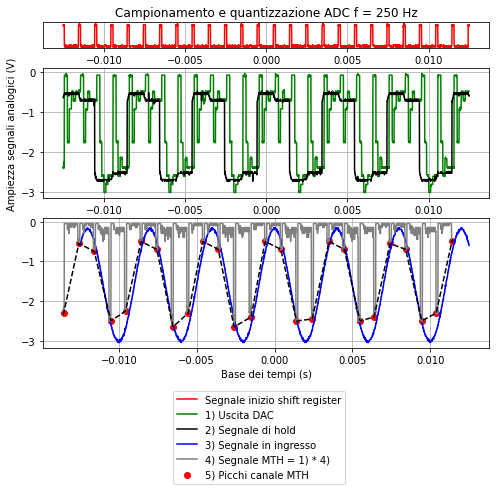

In [30]:
s = '18'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()
ch4_f = openTek(filePrefix + s+"CH4.CSV")['Data'].to_numpy().transpose()
mth_f = openTek(filePrefix + s+"MTH.CSV")['Data'].to_numpy().transpose()

sf = 0.00107

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]
ch4_t = ch4_f[0]
ch4_s = ch4_f[1]
mth_t = mth_f[0]-sf
mth_s = mth_f[1]/ch2_s.max()

p = list(scipy.signal.find_peaks(mth_s * -1., distance=90))[0]
#p_ok = [   3,  100,  199,  306,  394,  499,  601,  704,  803,  896,  996,  1097, 1206, 1296, 1398, 1497, 1599, 1706,1805, 1905, 1996, 2098,2199, 2302, 2395, 2496]
res = [i for i in range(0,len(p)-1) if i%2==0]

xint = np.linspace(mth_t.min(), mth_t.max(), 500) 
spl = make_interp_spline(mth_t[p], mth_s[p], k=1)  # type: BSpline
interp = spl(xint)

gs_kw = dict(height_ratios=[1,5,5])
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 250 Hz")
ax[1].plot(ch1_t, ch1_s, color = "green", label = "1) Uscita DAC") #Campionamento all bits
ax[1].plot(ch3_t, ch3_s, color = "black", label="2) Segnale di hold")
ax[2].plot(ch4_t, ch4_s, color = "blue", label="3) Segnale in ingresso")
ax[2].plot(mth_t, mth_s, color = "grey", label="4) Segnale MTH = 1) * 4)")

ax[2].scatter(mth_t[p], mth_s[p], color = "red",label = "5) Picchi canale MTH")
ax[2].plot(xint, interp, color = "black", linestyle = "--")

ax[0].plot(ch2_t, ch2_s/5, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[-1].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.2))

plt.savefig(f"{OUTPUTDIR}/campionamento_250Hz.pdf")


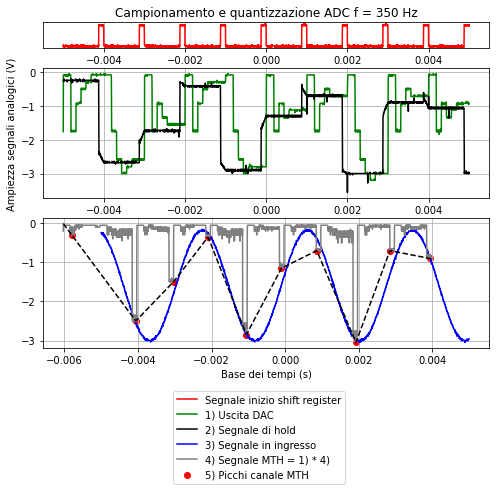

In [36]:
s = '19'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()
ch4_f = openTek(filePrefix + s+"CH4.CSV")['Data'].to_numpy().transpose()
mth_f = openTek(filePrefix + s+"MTH.CSV")['Data'].to_numpy().transpose()

sf = 0.00103

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]
ch4_t = ch4_f[0]
ch4_s = ch4_f[1]
mth_t = mth_f[0]-sf
mth_s = mth_f[1]/ch2_s.max()

p = list(scipy.signal.find_peaks(mth_s * -1., distance=200))[0]
p_ok = [ 58,  493,    749,
         984, 1244,  1682,  1988, 
       2158,  2405, 2449, 2489]
xint = np.linspace(mth_t.min(), mth_t.max(), 500) 
spl = make_interp_spline(mth_t[p], mth_s[p], k=1)  # type: BSpline
interp = spl(xint)


gs_kw = dict(height_ratios=[1,5,5])
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 350 Hz")
ax[1].plot(ch1_t, ch1_s, color = "green", label = "1) Uscita DAC") #Campionamento all bits
ax[1].plot(ch3_t, ch3_s, color = "black", label="2) Segnale di hold")
ax[2].plot(ch4_t, ch4_s, color = "blue", label="3) Segnale in ingresso")
ax[2].plot(mth_t, mth_s, color = "grey", label="4) Segnale MTH = 1) * 4)")

ax[2].scatter(mth_t[p], mth_s[p], color = "red",label = "5) Picchi canale MTH")
ax[2].plot(xint, interp, color = "black", linestyle = "--")

ax[0].plot(ch2_t, ch2_s/5, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[-1].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.2))

plt.savefig(f"{OUTPUTDIR}/campionamento_350Hz.pdf")

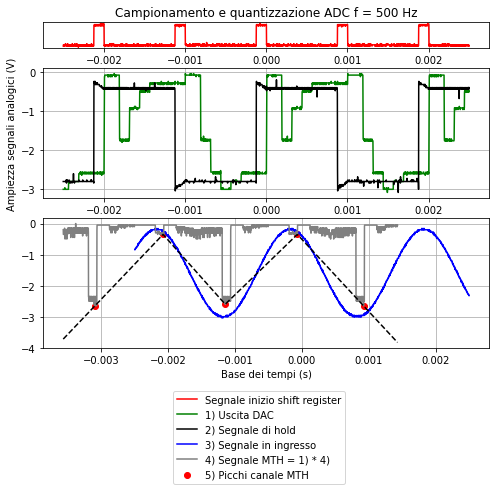

In [32]:
s = '20'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()
ch4_f = openTek(filePrefix + s+"CH4.CSV")['Data'].to_numpy().transpose()
mth_f = openTek(filePrefix + s+"MTH.CSV")['Data'].to_numpy().transpose()

sf = 0.00107

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]
ch4_t = ch4_f[0]
ch4_s = ch4_f[1]
mth_t = mth_f[0] -sf
mth_s = mth_f[1]/ch2_s.max()

p = list(scipy.signal.find_peaks(mth_s * -1., distance=400))[0]

xint = np.linspace(mth_t.min(), mth_t.max(), 500) 
spl = make_interp_spline(mth_t[p], mth_s[p], k=1)  # type: BSpline
interp = spl(xint)

gs_kw = dict(height_ratios=[1,5,5])
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 500 Hz")
ax[1].plot(ch1_t, ch1_s, color = "green", label = "1) Uscita DAC") #Campionamento all bits
ax[1].plot(ch3_t, ch3_s, color = "black", label="2) Segnale di hold")
ax[2].plot(ch4_t, ch4_s, color = "blue", label="3) Segnale in ingresso")
ax[2].plot(mth_t, mth_s, color = "grey", label="4) Segnale MTH = 1) * 4)")

ax[2].scatter(mth_t[p], mth_s[p], color = "red",label = "5) Picchi canale MTH")
ax[2].plot(xint, interp, color = "black", linestyle = "--")

ax[0].plot(ch2_t, ch2_s/5, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[-1].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.2))

plt.savefig(f"{OUTPUTDIR}/campionamento_500Hz.pdf")

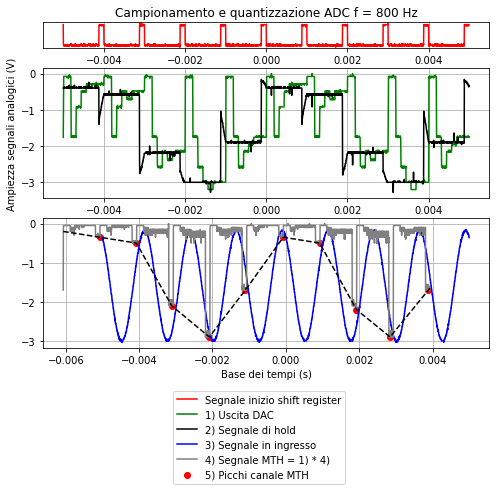

In [37]:
s = '21'
filePrefix = f"{DATADIR}/2-11-21/ALL00"+s+"/F00"
ch1_f = openTek(filePrefix + s+"CH1.CSV")['Data'].to_numpy().transpose()
ch2_f = openTek(filePrefix + s+"CH2.CSV")['Data'].to_numpy().transpose()
ch3_f = openTek(filePrefix + s+"CH3.CSV")['Data'].to_numpy().transpose()
ch4_f = openTek(filePrefix + s+"CH4.CSV")['Data'].to_numpy().transpose()
mth_f = openTek(filePrefix + s+"MTH.CSV")['Data'].to_numpy().transpose()

sf = 0.00107

ch1_t = ch1_f[0]
ch1_s = ch1_f[1]
ch2_t = ch2_f[0]
ch2_s = ch2_f[1]
ch3_t = ch3_f[0]
ch3_s = ch3_f[1]
ch4_t = ch4_f[0]
ch4_s = ch4_f[1]
mth_t = mth_f[0]-sf
mth_s = mth_f[1]/ch2_s.max()

p = list(scipy.signal.find_peaks(mth_s * -1., distance=200))[0]

xint = np.linspace(mth_t.min(), mth_t.max(), 500) 
spl = make_interp_spline(mth_t[p], mth_s[p], k=1)  # type: BSpline
interp = spl(xint)

gs_kw = dict(height_ratios=[1,5,5])
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 6), gridspec_kw=gs_kw)

ax[0].axes.yaxis.set_visible(False)
ax[0].set(title = "Campionamento e quantizzazione ADC f = 800 Hz")
ax[1].plot(ch1_t, ch1_s, color = "green", label = "1) Uscita DAC") #Campionamento all bits
ax[1].plot(ch3_t, ch3_s, color = "black", label="2) Segnale di hold")
ax[2].plot(ch4_t, ch4_s, color = "blue", label="3) Segnale in ingresso")
ax[2].plot(mth_t, mth_s, color = "grey", label="4) Segnale MTH = 1) * 4)")

ax[2].scatter(mth_t[p], mth_s[p], color = "red",label = "5) Picchi canale MTH")
ax[2].plot(xint, interp, color = "black", linestyle = "--")

ax[0].plot(ch2_t, ch2_s/5, color = "red", label = "Segnale inizio shift register")
ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[-1].set(xlabel = "Base dei tempi (s)")
ax[1].set(ylabel = "Ampiezza segnali analogici (V)")
fig.legend(loc = "lower center", bbox_to_anchor = (0.5, -0.2))

plt.savefig(f"{OUTPUTDIR}/campionamento_800Hz.pdf")